In [2]:
import syft as sy
from utils import *
from syft.core.adp.data_subject_list import NewDataSubject

/home/shubham/anaconda3/envs/syft/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 19.8M  100 19.8M    0     0  4036k      0  0:00:05  0:00:05 --:--:-- 5388k


BreastCancerDataset-02ec48b840824b1ea3e1f5d11c45314b.pkl is successfully downloaded.
Columns: Index(['patient_ids', 'labels', 'images'], dtype='object')
Total Images: 2775
Label Mapping {'Non-Invasive Ductal Carcinoma (IDC)': 0, 'Invasive Ductal Carcinoma (IDC)': 1}


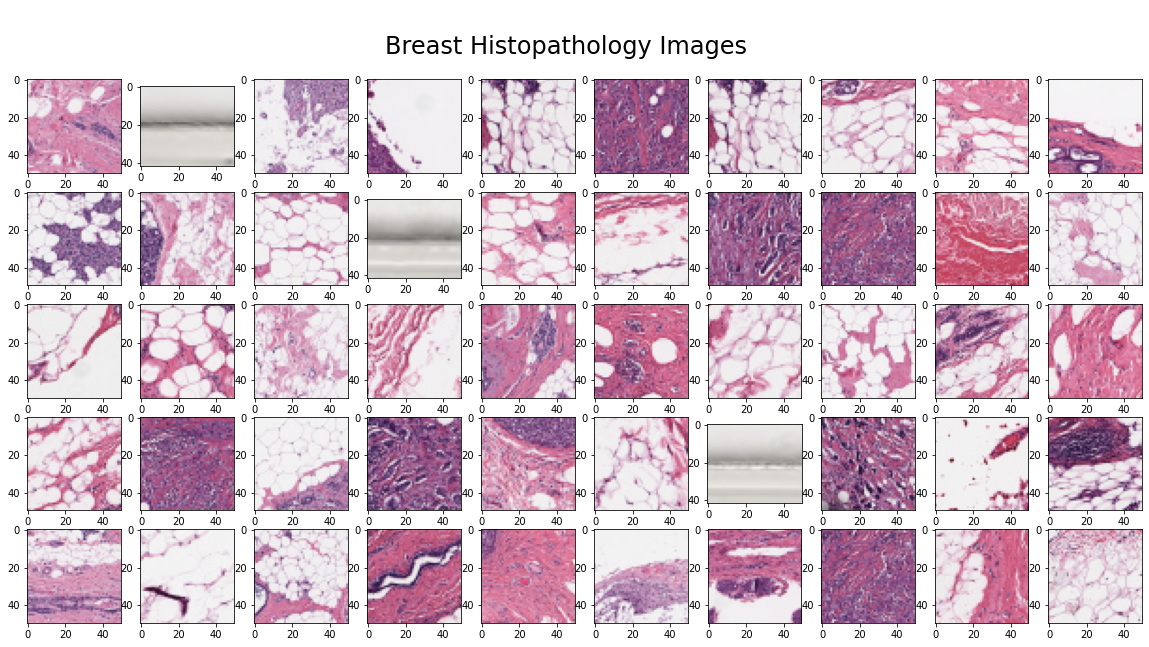

In [3]:
MY_DATASET_URL = "https://raw.githubusercontent.com/OpenMined/datasets/main/BreastCancerDataset/subsets/BreastCancerDataset-02ec48b840824b1ea3e1f5d11c45314b.pkl"
dataset = download_dataset(MY_DATASET_URL)

In [4]:
dataset.head()

,patient_ids,labels,images
0,22545,0,"[[[223, 204, 216], [238, 234, 238], [234, 228,..."
1,22545,0,"[[[205, 100, 129], [197, 86, 122], [188, 80, 1..."
2,22545,0,"[[[227, 205, 215], [204, 143, 176], [218, 169,..."
3,22545,0,"[[[239, 227, 230], [234, 197, 214], [240, 229,..."
4,22545,0,"[[[234, 221, 227], [234, 218, 227], [240, 238,..."


In [5]:
# run this cell
train, val, test = split_and_preprocess_dataset(data=dataset)

Splitting dataset into train, validation and test sets.
Preprocessing the dataset...
Dims (2237, 3, 50, 50)
Dims (275, 3, 50, 50)
Dims (263, 3, 50, 50)
Preprocessing completed.


In [6]:
# run this cell
data_subjects_image = np.ones(train["images"].shape).astype(object)
for i,patient in enumerate(train["patient_ids"]):
    data_subjects_image[i] = NewDataSubject([str(patient)])

data_subjects_labels = np.ones(train["labels"].shape).astype(object)
for i,patient in enumerate(train["patient_ids"]):
    data_subjects_labels[i] = NewDataSubject([str(patient)])

    
train_image_data = sy.Tensor(train["images"]).annotated_with_dp_metadata(
    min_val=0, max_val=255, data_subjects=data_subjects_image
)
train_label_data = sy.Tensor(train["labels"]).annotated_with_dp_metadata(
    min_val=0, max_val=1, data_subjects=data_subjects_labels
)

Tensor annotated with DP Metadata
Tensor annotated with DP Metadata


In [7]:
# from syft import PhiTensor
# def correct_dsl(input_tensor: PhiTensor):
#     """ Corrects for the new DSL shape requirements 
#     e.g. (1915,) -> (1915, 3, 50, 50) 
#     """
#     output_dsi = np.ones((input_tensor.shape[0], *input_tensor.shape[1:]))
#     print(output_dsi.shape)
    
#     for index, val in enumerate(input_tensor.data_subjects.data_subjects_indexed[0]):
#         output_dsi[index] *= val
    
#     input_tensor.data_subjects.data_subjects_indexed = output_dsi
#     # print(output_dsi.shape)
#     # print(output_dsi[0])
#     # output_dsi = np.ones(input_tensor.shape)  # b/c PhiTensor
#     # for i in range(input_tensor.shape[0]):
#     #      output_dsi[i] *= input_tensor.data_subjects.data_subjects_indexed[i]
#     # input_tensor.data_subjects.data_subjects_indexed = output_dsi

# correct_dsl(train_image_data.child)  
# # .shape, train_image_data.child.data_subjects.shape

In [8]:
# data_subjects = DataSubjectList.from_series(val["patient_ids"])
# val_image_data = sy.Tensor(val["images"]).annotated_with_dp_metadata(
#     min_val=0, max_val=255, data_subjects=data_subjects
# )
# val_label_data = sy.Tensor(val["labels"]).annotated_with_dp_metadata(
#     min_val=0, max_val=1, data_subjects=data_subjects
# )

In [9]:
# data_subjects = DataSubjectList.from_series(test["patient_ids"])
# test_image_data = sy.Tensor(test["images"]).annotated_with_dp_metadata(
#     min_val=0, max_val=255, data_subjects=data_subjects
# )
# test_label_data = sy.Tensor(test["labels"]).annotated_with_dp_metadata(
#     min_val=0, max_val=1, data_subjects=data_subjects
# )

### Model Training

In [10]:
from syft import nn

In [11]:
input_shape = train_image_data.public_shape
input_shape

(2237, 3, 50, 50)

In [12]:
y_train = train_label_data

In [13]:
model = nn.Model()

# Layer 1
model.add(nn.Convolution(nb_filter=32, filter_size=3, padding=2, input_shape=input_shape))
model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
model.add(nn.MaxPool(pool_size=2, stride=2))

# # Layer 2
model.add(nn.Convolution(nb_filter=64, filter_size=3, padding=2))
model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
model.add(nn.MaxPool(pool_size=2, stride=2))

# Layer 3
model.add(nn.Convolution(nb_filter=128, filter_size=3, padding=2))
model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
model.add(nn.MaxPool(pool_size=2, stride=2))

# Layer 4
model.add(nn.Convolution(nb_filter=256, filter_size=3, padding=2))
model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
model.add(nn.MaxPool(pool_size=2, stride=2))

# Layer 5
# model.add(nn.Convolution(nb_filter=512, filter_size=3, padding=2))
# model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
# model.add(nn.MaxPool(pool_size=2, stride=2))

# Layer 6
model.add(nn.AvgPool(5))

# # Layer 7
model.add(nn.Flatten())

# # Layer 8
model.add(nn.Linear(2))

In [14]:
model.compile()

In [15]:
train_image_data.child.shape, train_image_data.child.data_subjects.shape

((2237, 3, 50, 50), (2237, 3, 50, 50))

In [16]:
# for i in train_image_data.child.data_subjects.data_subjects_indexed.flatten():
#     print(i)
#     break


(1, 1881) * ones((1881, 3, 50, 50))

In [17]:
train_image_data.child.shape, train_image_data.child.data_subjects.shape

((2237, 3, 50, 50), (2237, 3, 50, 50))

In [18]:
out = train_image_data[:2].child

In [19]:
out.shape, out.data_subjects.shape

((2, 3, 50, 50), (2, 3, 50, 50))

In [20]:
import time
total_time = 0.0
for layer in model.layers:
    start  = time.time()
    print("Layer Name: ", layer)
    out = layer.forward(out)
    end = time.time()
    print(f"Time for Layer: {layer}" , end-start)
    total_time += (end-start)
    print()

Layer Name:  Convolution
Input into Conv forward: (2, 3, 50, 50) (2, 3, 50, 50)
shapes before padding:,  (2, 3, 50, 50) (2, 3, 50, 50)
dsi_shape, width, mode (2, 3, 50, 50) ((0, 0), (0, 0), (2, 2), (2, 2)) reflect
x_padded (2, 3, 54, 54)
cols before (2, 27, 2704)
cols transpose (27, 5408)
out after matmul (5408, 32) (5408, 32)
out after reshape (32, 52, 52, 2) (32, 52, 52, 2)
out after transpose (2, 32, 52, 52) (2, 32, 52, 52)
out after matmul (2, 32, 52, 52) (2, 32, 52, 52)
Done with convolution
Time for Layer: Convolution 3.214916229248047

Layer Name:  BatchNorm
input shapes (2, 32, 52, 52) (2, 32, 52, 52)
PT mean gives shape of (2, 52, 52)
mean shapes after expand (2, 1, 52, 52) (2, 1, 52, 52)
xmu shapes (2, 32, 52, 52) (2, 32, 52, 52)


CAN YOU HEAR ME
reshaping to: (2, 1, 52, 52)
og shape (2, 52, 52)
target shape [2, 1, 52, 52]
var shapes (2, 1, 52, 52) (2, 1, 52, 52)
sqrtvar shapes (2, 1, 52, 52) (2, 1, 52, 52)
ivar shapes (2, 1, 52, 52) (2, 1, 52, 52)
xhat shapes (2, 32, 52, 52) (2, 32, 52, 52)
gamma shapes (2, 32, 52, 52) (2, 32, 52, 52)
out shapes (2, 32, 52, 52) (2, 32, 52, 52)
activated out shapes (2, 32, 52, 52) (2, 32, 52, 52)
Time for Layer: BatchNorm 4.2757568359375

Layer Name:  MaxPool
shapes before padding:,  (64, 1, 52, 52) (64, 1, 52, 52)
dsi_shape, width, mode (64, 1, 52, 52) ((0, 0), (0, 0), (0, 0), (0, 0)) reflect
x_padded (64, 1, 52, 52)
cols before (64, 4, 676)
cols transpose (4, 43264)
FInished im2col, starting _argmax
outputs, DSL shape: (43264,) (43264,)
reshaped outputs, DSL shape: (26, 26, 2, 32) (26, 26, 2, 32)
transposed outputs, DSL shape: (2, 32, 26, 26) (2, 32, 26, 26)
Done with MaxPool forward pass
Time for Layer: MaxPool 0.0709071159362793

Layer Name:  Convolution
Input into Conv forw

In [21]:
out.shape, out.data_subjects.shape

((2, 2), (2, 2))

In [22]:
# Total time to execute forward pass
total_time

94.60089683532715

### Loss calculation

In [23]:
out.child.shape

(2, 2)

In [24]:
out.child

DeviceArray([[ 0.58428255, -2.55681596],
             [ 0.63045096, -2.651747  ]], dtype=float64)

In [25]:
y_true = train_label_data[:2].child

In [30]:
y_true

PhiTensor(child=[0 0], min_vals=<lazyrepeatarray data: 0 -> shape: (2,)>, max_vals=<lazyrepeatarray data: 0 -> shape: (2,)>)

In [26]:
y_true.shape

(2,)

In [27]:
y_true

PhiTensor(child=[0 0], min_vals=<lazyrepeatarray data: [0 0] -> shape: (2,)>, max_vals=<lazyrepeatarray data: [0 0] -> shape: (2,)>)

In [28]:
train_label_data.child[:10]

PhiTensor(child=[0 0 0 0 0 0 0 0 0 0], min_vals=<lazyrepeatarray data: [0 0 0 0 0 0 0 0 0 0] -> shape: (10,)>, max_vals=<lazyrepeatarray data: [0 0 0 0 0 0 0 0 0 0] -> shape: (10,)>)

In [29]:
next_grad = model.loss.backward(out, y_true)

In [30]:
next_grad.data_subjects.shape

(2, 2)

In [31]:
total_time_backward = 0.0
for layer in model.layers[::-1]:
    print(layer)
    start = time.time()
    next_grad = layer.backward(next_grad)
    end = time.time()
    print(f"Time to execute backward for {layer}: {end-start}")
    total_time_backward += end-start

Linear
Time to execute backward for Linear: 0.20100688934326172
Flatten
Time to execute backward for Flatten: 0.03763413429260254
AvgPool


IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

In [ ]:
layer.last_input_shape

In [ ]:
next_grad.data_subjects.shape

In [ ]:
next_grad.shape

In [ ]:
64*14*14

In [ ]:
layer.last_input.T.dot(next_grad) 

In [ ]:
next_grad.data_subjects.shape

In [ ]:
model.fit(train_image_data.child, train_label_data.child, shuffle=False, max_iter=1)

####Debubbing

In [ ]:
import syft as sy

In [ ]:
class DSL:
    __attr_allowlist__ = ("data_subjects",)

    def __init__(self, data_subjects):
        self.data_subjects = set(data_subjects)

    def __add__(self, other):
        if isinstance(other, DSL):
            return DSL(self.data_subjects.union(other.data_subjects))
        else:
            return DSL(self.data_subjects)

    def __sub__(self, other):
        if isinstance(other, DSL):
            return DSL(self.data_subjects.union(other.data_subjects))
        else:
            return DSL(self.data_subjects)

    def __mul__(self, other):
        if isinstance(other, DSL):
            return DSL(self.data_subjects.union(other.data_subjects))
        else:
            return DSL(self.data_subjects)
        
    def __ge__(self, other):
        if isinstance(other, DSL):
            return DSL(self.data_subjects.union(other.data_subjects))
        else:
            return DSL(self.data_subjects)
    
    def __le__(self, other):
        if isinstance(other, DSL):
            return DSL(self.data_subjects.union(other.data_subjects))
        else:
            return DSL(self.data_subjects)

    def __truediv__(self, other):
        if isinstance(other, DSL):
            return DSL(self.data_subjects.union(other.data_subjects))
        else:
            return DSL(self.data_subjects)
    
    def __rtruediv__(self, other):
            return DSL(self.data_subjects)

    def __repr__(self):
        return "DSL: " + str(self.data_subjects.__repr__())
    
    def conjugate(self,*args,**kwargs):
        return DSL(self.data_subjects)
    
    def subtract(self,x,y,*args, **kwargs):
        if isinstance(y, DSL) and isinstance(x,DSL):
            return DSL(x.data_subjects.union(y.data_subjects))
        elif isinstance(y, DSL):
            return DSL(y.data_subjects)
        elif isinstance(x, DSL):
            return DSL(x.data_subjects)
    
    def multiply(self,x,y,*args, **kwargs):
        if isinstance(y, DSL) and isinstance(x,DSL):
            return DSL(x.data_subjects.union(y.data_subjects))
        elif isinstance(y, DSL):
            return DSL(y.data_subjects)
        elif isinstance(x, DSL):
            return DSL(x.data_subjects)
    
    def real(self):
        return DSL(self.data_subjects)

    def var(self,*args, **kwargs):
        return  ((self  - np.mean(self))*(self  - np.mean(self)))

    def sqrt(self,*args, **kwargs):
        return DSL(self.data_subjects)

    def __array_ufunc__(self, ufunc, method, *inputs, **kwargs):
        method_name = ufunc.__name__
        print("method_name",method_name)
        method  = getattr(self,method_name,None)
        if method is not None:
            return method(*inputs, **kwargs)
        else:
            raise NotImplementedError(f"Method: {method_name} not implemented in DSL")
        

        
            

In [ ]:
from syft.core.adp.data_subject_list import NewDataSubject

In [ ]:
a = np.array([["ishan","shubham"],["ishan","shubham"]])

In [ ]:
a>0

In [ ]:
squarer = lambda t: NewDataSubject([t])

In [ ]:
v = np.vectorize(squarer)

In [ ]:
dsl = v(a)

In [ ]:
dsl.__gt__(0)

In [ ]:
dsl.mean(dsl)

In [ ]:
np.fliplr(dsl)

In [ ]:
val = np.random.random((3,5,5))
print(val)
print(np.fliplr(val))

In [ ]:
np.fliplr(val)

In [ ]:
import numpy as np

In [ ]:
np.array(DSL("A"))/np.array([1])

In [ ]:
axis=None, dtype=None, out=None,keepdims=False,where=True

In [ ]:
ret = np.add.reduce(np.array(DSL("A")), axis=None, dtype=None, out=None,keepdims=False,where=True)

In [ ]:
ret/5

In [ ]:
from syft.core.adp.data_subject_list import NewDataSubject as DSL

In [ ]:
import syft as sy

In [ ]:
sy.deserialize(sy.serialize(DSL("A")))

In [ ]:
import numpy as np

In [ ]:
a = np.array([ [ [DSL("A"),DSL("B")], [DSL("C"),DSL("D") ]],[[DSL("A"),DSL("B")], [DSL("C"),DSL("D") ]]])

In [ ]:
np.squeeze(a,None)

In [ ]:
np.maximum(a,a)

In [ ]:
b = np.array([[1,2],[3,4]])

In [ ]:
sy.deserialize(sy.serialize(a.tolist()))

In [ ]:
b = np.array([ [DSL("B"),DSL("B")], [DSL("C"),DSL("C") ]])

In [ ]:
a

In [ ]:
b

In [ ]:
a.mean(axis=0)

In [ ]:
a.dot(np.array([[1,2],[3,4]]))

In [ ]:
a

In [ ]:
from syft import PhiTensor

In [ ]:
import numpy as np

In [ ]:
data_subjects1 = [["cicada","cicada"],["cicada","cicada"]]
data_subjects2 = [["3301","3301"],["3301","3301"]]

In [ ]:
a = PhiTensor(child = np.array([[1,2],[3,4]]),min_vals = 1,max_vals=4,data_subjects=data_subjects1)
b = PhiTensor(child = np.array([[1,2],[3,4]]),min_vals = 1,max_vals=4,data_subjects=data_subjects2)

In [ ]:
a.data_subjects

In [ ]:
b.data_subjects

In [ ]:
v = a+b

In [ ]:
v.data_subjects

In [ ]:
np.std(b,axis=0)

In [ ]:
c  = np.array([[1,1,1],[1,1,1]])

In [ ]:
np.conjugate(c)

In [ ]:
b.dot(c)

In [ ]:
np.array(a.mean())

In [ ]:
x = np.array([[1,2,3]])

In [ ]:
y = np.array([[4]])

In [ ]:
x+y

In [ ]:
x = np.array([[DSL("1"),DSL("2"),DSL("3")]])

In [ ]:
y = np.array([[DSL("4")]])

In [ ]:
x+y